In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import os

# import problems to solve
import problems
import experiments
import train
import topo_api
import topo_physics
import models

from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
def constrained_structural_optimization_function(model, ke, args, designs, losses):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )
    x_phys = torch.sigmoid(logits)

    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)

    # Calculate the u_matrix
    u_matrix, _ = topo_physics.sparse_displace(
        x_phys, ke, forces, args["freedofs"], args["fixdofs"], **kwargs
    )

    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)

    # The loss is the sum of the compliance
    f = torch.sum(compliance_output)

    # Run this problem with no inequality constraints
    ci = None

    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = 1e4 * torch.abs(torch.mean(x_phys) - args['volfrac'])

    # Append updated physical density designs
    designs.append(
        x_phys
    )  # noqa

    return f, ci, ce

In [5]:
# Identify the problem
problem = problems.mbb_beam(height=20, width=60)
problem.name = 'mbb_beam'

# cnn_kwargs
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

# Get the problem args
args = topo_api.specified_task(problem)

# Initialize the CNN Model
if cnn_kwargs is not None:
    cnn_model = models.CNNModel(args, **cnn_kwargs)
else:
    cnn_model = models.CNNModel(args)

# Put the cnn model in training mode
cnn_model.train()

# Create the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args["young"],
    poisson=args["poisson"],
)

# Create the combined function and structural optimization
# setup
# Save the physical density designs & the losses
designs = []
losses = []
# Combined function
comb_fn = lambda model: constrained_structural_optimization_function(  # noqa
    model, ke, args, designs, losses
)

# Initalize the pygranso options
opts = pygransoStruct()

# Set the device
opts.torch_device = torch.device('cpu')

# Setup the intitial inputs for the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional pygranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 150
opts.print_frequence = 10
opts.stat_l2_model = False

# Other parameters that helped the structural optimization
# problem
opts.init_step_size = 5e-5
opts.linesearch_maxit = 50
opts.linesearch_reattempts = 15

# Train pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:69: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:70: UserWarning: __floordiv__ is deprecated, and its behavior will change



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

/Users/ryandevera/.pyenv/versions/3.9.11/lib/python3.9/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


   2 ║ 0.810000 │  746.328321071 ║  706.147197249 ║   -  │ 174.3491 ║ S  │    11 │ 0.051200 ║     1 │ 0.265364   ║ 
   3 ║ 0.810000 │  671.789636776 ║  622.826819380 ║   -  │ 167.2999 ║ S  │    11 │ 0.051200 ║     1 │ 0.174362   ║ 
   4 ║ 0.810000 │  515.148377372 ║  513.988710281 ║   -  │ 98.81752 ║ S  │    14 │ 0.409600 ║     1 │ 0.128256   ║ 
   5 ║ 0.810000 │  447.979284286 ║  451.327523084 ║   -  │ 82.40399 ║ S  │    13 │ 0.204800 ║     1 │ 0.113614   ║ 
   6 ║ 0.810000 │  395.769318076 ║  405.270925878 ║   -  │ 67.49987 ║ S  │    16 │ 0.614400 ║     1 │ 0.117206   ║ 
   7 ║ 0.810000 │  392.203546373 ║  401.621150518 ║   -  │ 66.89041 ║ S  │     9 │ 0.012800 ║     1 │ 0.325166   ║ 
   8 ║ 0.810000 │  319.973246970 ║  330.182113746 ║   -  │ 52.52573 ║ S  │    14 │ 0.409600 ║     1 │ 0.139322   ║ 
   9 ║ 0.810000 │  286.600089782 ║  284.148704124 ║   -  │ 56.43964 ║ S  │    16 │ 1.638400 ║     1 │ 0.060503   ║ 
  10 ║ 0.810000 │  235.927632038 ║  280.604088671 ║   -  │ 8.638320 ║ S 

  61 ║ 0.027813 │  6.49463790424 ║  233.327415763 ║   -  │ 0.005140 ║ S  │    14 │ 0.409600 ║     1 │ 0.016235   ║ 
  62 ║ 0.027813 │  6.49394769941 ║  233.292103226 ║   -  │ 0.005432 ║ S  │    10 │ 0.025600 ║     1 │ 0.040768   ║ 
  63 ║ 0.027813 │  6.49380198165 ║  233.286246442 ║   -  │ 0.005449 ║ S  │     7 │ 0.003200 ║     1 │ 0.070481   ║ 
  64 ║ 0.027813 │  6.49377279913 ║  233.284823115 ║   -  │ 0.005460 ║ S  │     2 │ 1.00e-04 ║     1 │ 0.551448   ║ 
  65 ║ 0.027813 │  6.49361266619 ║  233.247073728 ║   -  │ 0.006349 ║ S  │     9 │ 0.012800 ║     1 │ 0.035029   ║ 
  66 ║ 0.027813 │  6.48862253782 ║  233.008196091 ║   -  │ 0.008003 ║ S  │    13 │ 0.204800 ║     1 │ 108.7915   ║ 
  67 ║ 0.025032 │  5.82904541349 ║  232.745206737 ║   -  │ 0.003071 ║ S  │     9 │ 0.012800 ║     1 │ 198.8259   ║ 
  68 ║ 0.020276 │  4.72148458691 ║  232.536429090 ║   -  │ 0.006678 ║ S  │    11 │ 0.051200 ║     1 │ 0.368423   ║ 
  69 ║ 0.020276 │  4.72147364201 ║  232.535076800 ║   -  │ 0.006695 ║ S 

 121 ║ 0.002219 │  0.51077831366 ║  230.194008627 ║   -  │ 8.57e-05 ║ S  │     9 │ 0.012800 ║     1 │ 0.065024   ║ 
 122 ║ 0.002219 │  0.51076323966 ║  230.187646368 ║   -  │ 8.48e-05 ║ S  │     4 │ 4.00e-04 ║     1 │ 0.634563   ║ 
 123 ║ 0.002219 │  0.51076247546 ║  230.186911554 ║   -  │ 8.56e-05 ║ S  │     3 │ 7.50e-05 ║     2 │ 0.014994   ║ 
 124 ║ 0.002219 │  0.51076182916 ║  230.186022380 ║   -  │ 8.69e-05 ║ S  │     8 │ 0.002400 ║     3 │ 0.003176   ║ 
 125 ║ 0.002219 │  0.51076118656 ║  230.185656374 ║   -  │ 8.71e-05 ║ S  │     7 │ 0.003200 ║     3 │ 0.004382   ║ 
 126 ║ 0.002219 │  0.51066774192 ║  230.145115141 ║   -  │ 8.36e-05 ║ S  │    12 │ 0.038400 ║     1 │ 28.94386   ║ 
 127 ║ 0.002219 │  0.51066766940 ║  230.127680194 ║   -  │ 1.22e-04 ║ S  │     7 │ 0.003200 ║     1 │ 0.056814   ║ 
 128 ║ 0.002219 │  0.51065218651 ║  230.120109246 ║   -  │ 1.24e-04 ║ S  │    11 │ 0.051200 ║     1 │ 0.012203   ║ 
 129 ║ 0.002219 │  0.51062784008 ║  230.106349103 ║   -  │ 1.30e-04 ║ S 

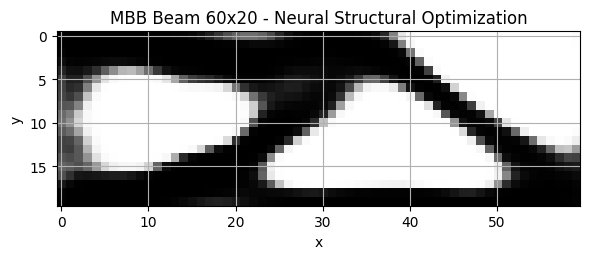

In [6]:
pygranso_structure = designs[-1].detach().numpy()

# Plot the two structures together
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

# pygranso
ax1.imshow(pygranso_structure, cmap='Greys')
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('MBB Beam 60x20 - Neural Structural Optimization')
fig.tight_layout()

In [ ]:
def constrained_structural_optimization_function(model, ke, args, designs, losses):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )
    x_phys = torch.sigmoid(logits)

    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)

    # Calculate the u_matrix
    u_matrix, _ = topo_physics.sparse_displace(
        x_phys, ke, forces, args["freedofs"], args["fixdofs"], **kwargs
    )

    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)

    # The loss is the sum of the compliance
    f = torch.sum(compliance_output)

    # Run this problem with no inequality constraints
    ci = None

    # Run this problem with no equality constraints
    ce = pygransoStruct()
    ce.c1 = 1e4 * torch.abs(torch.mean(x_phys) - args['volfrac'])

    # Append updated physical density designs
    designs.append(
        x_phys
    )  # noqa

    return f, ci, ce